# Anomaly Detection On Low Resolution Photography On The Martian Surface Using High Dimensional Tensor Decomposition

**Sandia National Laboratories**

**Prepared by:** Anthony Chan

**Date:** July, 2024


## Executive Summary

This study uses high dimensional tensor decomposition such as Tucker decomposition and CP(PARAFAC) decomposition to reduce the dimension of sequence of images into signals to train anomaly detection models to detect novel or anomalous objects on new image datasets. This study shows that Tucker decomposition with autoencoder achieved the highest performance with accuracy of 58% identified anomalies. Other anomaly detection techniques under Tucker's decomposition were performed such as one-class SVM, random forest, and ensemble of autoencoder and one-class SVM. CP decomposition was performed with one-class SVM, autoencoders, random forests and ensembled autoencoder with one-class SVM.

- **Key Findings:**
    - Tucker decomposition with autoencoder is the best performing model for this study. It is 2% more accurate than the second-best method- Tucker with one-class SVM. This was achieved using the decomposition rank of (95, 65, 65).
    
    
- **Main Recommendations:**
    - Performing Tucker decomposition on image sets to reduce them into 2-dimensional signals prior to anomaly detection is a performance effective way to detect anomalies.
    - Use of autoencoders with decomposed signals from Tucker decomposition is an effective machine learning method for detecting anomalies on images.

## Introduction

- **Background:**

The detection of novel or anomalous objects in images is a crucial task in many domains, including space exploration. Accurate anomaly detection can provide significant insights and facilitate critical decision-making processes. This project focuses on exploring novel method in anomaly detection by evaluating the effectiveness of two decomposition methods, CP (CANDECOMP/PARAFAC) and Tucker decomposition, in conjunction with machine learning models. Specifically, One-Class Support Vector Machines (OC-SVM), autoencoders, random forest, and their combination in detecting anomalies.

The image dataset used in this study comes from a previous research conducted by Kerner et al., featuring images captured by NASA's Mars Science Laboratory (MSL) Curiosity rover. This dataset provides a set of images, ideal for evaluating the proposed methods. Due to computational constraints, a subset of the original dataset was used, consisting of 200 images for training and 50 images for testing, to ensure reasonable convergence on a mid-performance laptop.

While this study utilizes low-resolution Martian photography, the methodologies and findings are not exclusive to this type of data. The approaches developed and tested in this project can be generalized and applied to other image sets in various domains, such as medical imaging, industrial inspection, and environmental monitoring, making the results widely applicable beyond the context of space exploration.

- **Objectives:**

    Evaluate Decomposition Methods: To compare the effectiveness of CP and Tucker decomposition techniques in reducing the dimensionality of image sets while retaining essential features for anomaly detection.
   
    Assess Anomaly Detection Models: To analyze the performance of different anomaly detection models, including OC-SVM, autoencoders, random forests, and an ensembled model combining OC-SVM and autoencoder, when trained on decomposed image signals.

    Determine Optimal Dimensions: To determine the optimal dimensionality or rank for each decomposition method that maximizes anomaly detection performance.

    Performance Metrics Analysis: To evaluate the performance of these models using metrics such as accuracy to identify the best combination of decomposition method and anomaly detection model.

## Methodology

#### **Data Collection:**

The image dataset used in this study was sourced from a prior research conducted by Kerner et al., which is hosted online. This dataset comprises images taken by NASA's Mars Science Laboratory (MSL) Curiosity rover. The original dataset is extensive, featuring a variety of images capturing different aspects of the Martian surface.

For the purpose of this study, a subset of the original dataset was used to ensure that the experiments could be conducted efficiently on a mid-performance laptop. This subset includes:

Training Set: 200 image sets. Of which, all images contain only normal/non-anomaly images

Testing Set: 50 images sets - Of which, 30 are anomalous and 20 are normal images

Each image set consists of 6 near similar images taken consecutively on the same object by the MSL camera, and each image is 64 x 64 resolution.

The selected subset provides a representative sample of the original dataset while allowing for reasonable convergence times during model training and testing.

**Dataset Download Instructions**:
The dataset used in this study has been reposted for convenience. You can download the subset of the dataset used for training and testing from the following link:

Download Subset Dataset - https://github.com/anthonycchan/omsa_practicum_dataset/tree/main

After downloading the dataset, please copy the downloaded folders into the same directory as this Jupyter Notebook to ensure that the file paths are correctly referenced during the execution of the code cells.

Please ensure the structure is as follows:

    /.
    
    /train_full

    /test_full

    /Anomaly Detection On Low Resolution Photography On The Martian Surface Using High Dimensional Tensor Decomposition.ipynb

### Import the necessary libraries

In [1]:
import numpy as np
import os
import re
import random
from sklearn.svm import OneClassSVM
from tensorly.decomposition import parafac, tucker
from sklearn.model_selection import GridSearchCV
from concurrent.futures import ThreadPoolExecutor, as_completed
import warnings
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import IsolationForest
from sklearn import metrics

### Set a randomization seed

In [2]:
random.seed(1)

### Read the data
Generic function to read the image sets.

In [3]:
# Step 1: Read the data, build the tensor
def readData(directory):
    directory = os.fsencode(directory)
    filelist = os.listdir(directory)
    numFiles = len(filelist)
    data_set = np.ones([numFiles, 64, 64, 6])
    true_labels = []
    i = 0
    for file in filelist:
        filename = os.fsdecode(file)

        # If the filename contains _MR_ then it is not an anomaly. If it contains _R#_ it is an anomaly.
        pattern = re.compile(r"_MR_")
        found = bool(pattern.search(filename))
        if found:
            true_labels.append(1)
        else:
            true_labels.append(-1)

        # Build the images into a tensor
        img_array = np.load(os.fsdecode(directory) + "/" + filename)
        data_set[i, :, :, :] = img_array
        i += 1

    return data_set, true_labels

### Dataset visualization

To better visualize the datasets, the following shows three sets of normal images.

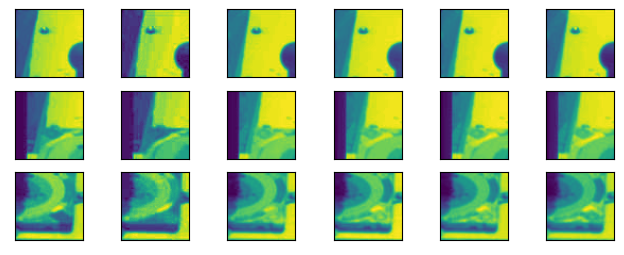

In [4]:
# Training images
X, true_labels = readData('train_full')

numSets=3
grid_size = (numSets, 6)
fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(8, 3))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

i=0
imageSetIndx={1,10,100}
for set_indx in imageSetIndx:
    img_array = X[set_indx, :, :, :]
    for j in range(grid_size[1]):
        axs[i, j].imshow(img_array[:,:,j])
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
    i = i+1

The following shows three sets of novel/anomalous images.

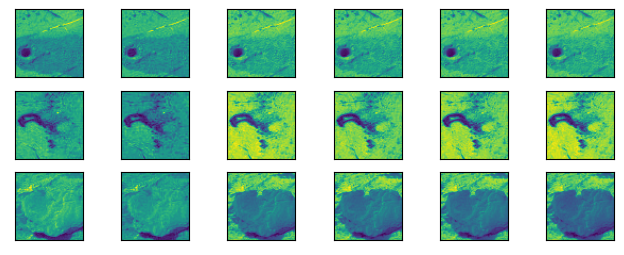

In [5]:
# Test images
X, true_labels = readData('test_full')

numSets=3
grid_size = (numSets, 6)
fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(8, 3))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

i=0
imageSetIndx={1,10,20}
for set_indx in imageSetIndx:
    img_array = X[set_indx, :, :, :]
    for j in range(grid_size[1]):
        axs[i, j].imshow(img_array[:,:,j])
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
    i = i+1

### Displaying the image sets as signals

The following code transforms each image set into a one-dimensional signal. The first 10 image sets of the training data are plotted below.

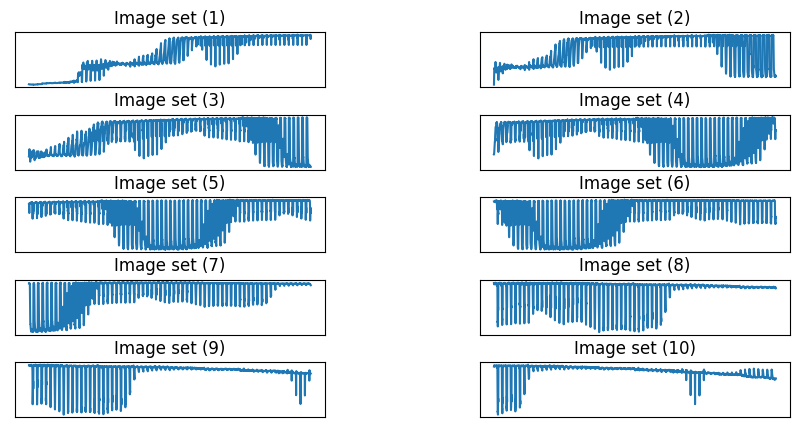

In [6]:
# Function to plot the image sets as signals by transforming image matrix into column wise order and averaging the
# images for each set. Each signal displayed is the average for an image set of six images. The following shows the
# first 10 image sets.
def plot_signals(X, num_sets):
    avgSignalsInSets = []
    for curSet in range(num_sets):
        image_set = X[curSet, :, :, :]
        n_images_in_set = image_set.shape[2]
        signal = np.zeros(image_set.shape[0] * image_set.shape[1])
        for i in range(n_images_in_set):
            signal = signal + image_set[:,:,i].ravel(order='F')
        signal = signal / n_images_in_set
        avgSignalsInSets.append(signal)

    grid_size = (5, 2)
    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 5))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    index = 0
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            axs[i, j].plot(avgSignalsInSets[index])
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            index = index + 1
            axs[i, j].set_title(f'Image set ({index})')

    plt.show()


data_set, true_labels = readData('train_full')
plot_signals(data_set, 10)

### CP (Parafac) Decomposition and Tucker's Decomposition
The following functions transforms an image tensor into low dimensional representation using CP and Tucker's decomposition.

    Function Name: decompose_tensor_tucker
    Description: Perfomrs Tucker's decomposition
    Parameters: 
        tensor : Image tensor.
        rank : 3-tuple value representing the rank of Tucker's decomposition. eg. (5,5,5)


    Function Name: decompose_tensor_parafac
    Description: Performs CP(Parafac) decomposition
    Parameters: 
        tensor : Image tensor.
        rank : Interger representing rank of CP (Parafac) decomposition.

    Function Name: buildTensor
    Description: Generic driver for decomposing an image tensor into either Tucker's decomposition or CP decomposition.
    Parameters: 
        X : Image tensor
        rank : Rank for either CP decomposition or Tucker's decomposition.
        num_sets : Number of sets in the image tensor X.
        isTuckerDecomposition : Boolean. True if Tucker's decomposition is to be performed, otherwise, CP decompositon.
        ordered : Boolean. True if order is to be preserved after decomposition.
        
    Function Name: extractFeatures
    Description: Converts the tensor into a two-dimensional array
    Parameters:
        decomposed_data : CP or Tucker decomposed images
        num_sets : Number of image sets in the decomposed images
        isTuckerDecomposition : Is conversion to be done on Tucker decomposed data (True) or CP decomposed data (False)

In [7]:
def decompose_tensor_tucker(tensor, rank):
    core, factors = tucker(tensor, rank)
    return core, factors

def decompose_tensor_parafac(tensor, rank):
    weights, factors = parafac(tensor, rank=rank)
    return factors

def extract_features_tucker(core, factors):
    core_flattened = core.ravel()
    factors_flattened = np.concatenate([factor.ravel() for factor in factors], axis=0)
    return np.concatenate((core_flattened, factors_flattened), axis=0)

def extract_features_cp(factors):
    return np.concatenate([factor.ravel() for factor in factors], axis=0)

def buildTensor(X, rank, num_sets, isTuckerDecomposition=True, ordered=False):
    decomposed_data = {}
    if ordered:
        # Use multithreading for tensor decomposition
        if isTuckerDecomposition == True:
            with ThreadPoolExecutor() as executor:
                future_to_index = {executor.submit(decompose_tensor_tucker, X[i], rank): i for i in
                                   range(num_sets)}
                # Make sure decomposition comes back in order as the original order of the test data
                for future in as_completed(future_to_index):
                    index = future_to_index[future]
                    decomposed_data[index] = future.result()
        else:
            #decomposed_data = [decompose_tensor_parafac(X[i], rank) for i in range(num_sets)]
            with ThreadPoolExecutor() as executor:
                future_to_index = {executor.submit(decompose_tensor_parafac, X[i], rank): i for i in
                                   range(num_sets)}
                # Make sure decomposition comes back in order as the original order of the test data
                for future in as_completed(future_to_index):
                    index = future_to_index[future]
                    decomposed_data[index] = future.result()

    else:
        # Use multithreading for tensor decomposition
        if isTuckerDecomposition == True:
            with ThreadPoolExecutor() as executor:
                futures = [executor.submit(decompose_tensor_tucker, X[i], rank) for i in range(num_sets)]
                decomposed_data = [future.result() for future in as_completed(futures)]
        else:
            with ThreadPoolExecutor() as executor:
                future_to_decomp = {executor.submit(decompose_tensor_parafac, X[i], rank): i for i in range(num_sets)}
                decomposed_data = [future.result() for future in as_completed(future_to_decomp)]
    return decomposed_data

def extractFeatures(decomposed_data, num_sets, isTuckerDecomposition=True):
    # Use multithreading for feature extraction
    if isTuckerDecomposition == True:
        with ThreadPoolExecutor() as executor:
            futures = [executor.submit(extract_features_tucker, decomposed_data[i][0], decomposed_data[i][1]) for i in
                       range(num_sets)]
            features = [future.result() for future in as_completed(futures)]
    else:
        with ThreadPoolExecutor() as executor:
            future_to_features = {
                executor.submit(extract_features_cp, decomposed_data[i]) for i in range(num_sets)}
            features = [future.result() for future in as_completed(future_to_features)]
    features = np.array(features)
    return features

### Use predefined rank
The following option saves time by not having to search for the optimal rank. It instead uses a pre-trained optimal rank. 

In [8]:
use_predefined_rank = True

### Activation variables
The following are activation variables which will allow the user to choose which experiment method to run. 

In [9]:
# Tucker's decomposition with one-class SVM 
enable_tucker_oc_svm = True
# Tucker's decomposition with neural-network autoencoders
enable_tucker_autoencoder = True
# Tucker's decomposition with random forest
enable_tucker_random_forest = True
# Tucker's decomposition with combination of autoencoder and one-class SVM.
enable_tucker_autoencoder_oc_svm = True
# CP decomposition with one-class SVM
enable_cp_oc_svm = True
# CP decomposition with neural-network autoencoders
enable_cp_autoencoder = True
# CP decomposition with random forest
enable_cp_random_forest = True
# CP decomposition with combination of autoencoder and one-class SVM.
enable_cp_autoencoder_oc_svm = True

### CP decomposition with One-Class SVM

    Function Name: parafac_OC_SVM
    Descripton: Performs CP(Parafac) decomposition with One-class SVM.
    Parameters: 
        rank: Rank for CP(Parafac) decomposition.
        displayConfusionMatrix : Displays confusion matrix.
    
    Function Name: cp_rank_search_one_class_svm
    Description: Finds the best rank for CP decomposition with One-class SVM based on prediction accuracy.
    Parameters:
        None

Running best rank CP OC-SVM
Prediction: [ 1  1 -1  1  1  1  1  1  1  1  1 -1  1 -1 -1 -1 -1  1  1  1  1  1 -1  1
  1 -1  1  1  1  1  1 -1 -1 -1  1 -1  1  1  1  1 -1  1  1  1 -1  1  1  1
  1  1]
True labels: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1]
Accuracy: 0.44
Best param: {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.1}


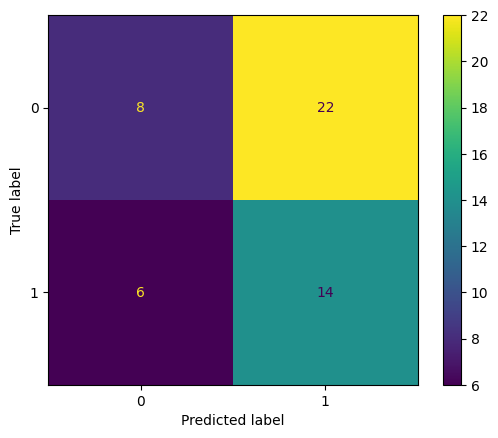

In [10]:
def parafac_OC_SVM(rank, displayConfusionMatrix=False):
    X, true_labels = readData('train_full')
    num_sets = X.shape[0]

    # Run CP decomposition
    decomposed_data = buildTensor(X, rank, num_sets, False)

    # Extract and normalize features
    features = extractFeatures(decomposed_data, num_sets, False)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Step 4: Train OC-SVM with Grid Search for Hyperparameter Tuning
    param_grid = {
        'nu': [0.1, 0.5, 0.9],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'poly', 'sigmoid']
    }

    # Suppress warnings
    warnings.filterwarnings('ignore', category=UserWarning)

    oc_svm = OneClassSVM()
    grid_search = GridSearchCV(oc_svm, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(features_scaled)
    best_oc_svm = grid_search.best_estimator_
    best_params = grid_search.best_params_

    ###
    ### Predict using the test set
    ###
    test_data_set, true_labels = readData('test_full')
    num_test_sets = test_data_set.shape[0]

    # Run CP decomposition
    decomposed_data = buildTensor(X, rank, num_test_sets, False, True)

    # Extract and normalize features
    features_test = extractFeatures(decomposed_data, num_test_sets, False)
    features_scaled_test = scaler.fit_transform(features_test)

    # Predict using the trained OC-SVM
    prediction = best_oc_svm.predict(features_scaled_test)
    print("Prediction:", prediction)  # 1 indicates normal, -1 indicates anomaly
    print('True labels:', true_labels)
    accuracy = sum(prediction == true_labels) / len(true_labels)
    print('Accuracy:', accuracy)
    print('Best param:', best_params)

    if displayConfusionMatrix:
        confusion_matrix = metrics.confusion_matrix(true_labels, prediction)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])
        cm_display.plot()
        plt.show()

    return accuracy

def cp_rank_search_one_class_svm():
    print('CP rank search One Class SVM')
    startRank = 10
    endRank = 100
    step = 5
    rank_accuracy = {}
    for i in range(startRank, endRank, step):
        print('Rank:', i)
        rank = i
        accuracy = parafac_OC_SVM(rank)
        rank_accuracy[rank] = accuracy
    print('Rank accuracy', rank_accuracy)
    bestRank = max(rank_accuracy, key=rank_accuracy.get)
    return bestRank, rank_accuracy[bestRank]


if enable_cp_oc_svm:
    if use_predefined_rank == False:
        bestRank, bestAccuracy = cp_rank_search_one_class_svm()
        print('Best Rank for CP with One Class SVM', bestRank, bestAccuracy)
    else:
        print('Running best rank CP OC-SVM')
        bestRank=80
        parafac_OC_SVM(bestRank, True)

#### Results
    Using CP decomposition with one-class SVM produces anomaly detection accuracy of 44% at rank 80.

### CP decomposition with Neural Networks Autoencoders

    Function Name: parafac_autoencoder
    Descripton: Performs CP(Parafac) decomposition with Autoencoder.
    Parameters: 
        rank : Rank for CP(Parafac) decomposition.
        displayConfusionMatrix : Displays confusion matrix.
    
    Function Name: cp_rank_search_autoencoder
    Description: Finds the best rank for CP decomposition with Autoencoder based on prediction accuracy.
    Parameters:
        None

Running best rank CP with autoencoder
Epoch 1/10
6/6 [==============================] - 7s 1s/step - loss: 1.0777 - val_loss: 0.8542
Epoch 2/10
6/6 [==============================] - 6s 997ms/step - loss: 1.0162 - val_loss: 0.8542
Epoch 3/10
6/6 [==============================] - 6s 981ms/step - loss: 1.0162 - val_loss: 0.8542
Epoch 4/10
6/6 [==============================] - 6s 976ms/step - loss: 1.0162 - val_loss: 0.8542
Epoch 5/10
6/6 [==============================] - 6s 966ms/step - loss: 1.0162 - val_loss: 0.8542
Epoch 6/10
6/6 [==============================] - 6s 973ms/step - loss: 1.0162 - val_loss: 0.8542
Epoch 7/10
6/6 [==============================] - 6s 959ms/step - loss: 1.0162 - val_loss: 0.8542
Epoch 8/10
6/6 [==============================] - 6s 966ms/step - loss: 1.0162 - val_loss: 0.8542
Epoch 9/10
6/6 [==============================] - 6s 966ms/step - loss: 1.0162 - val_loss: 0.8542
Epoch 10/10
2/2 [==============================] - 0s 34ms/step
Predictions [-1  1 

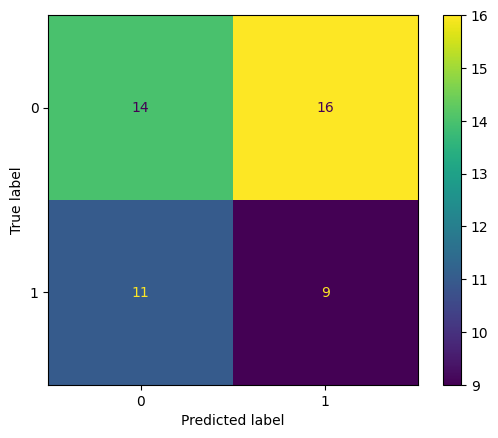

In [12]:
def parafac_autoencoder(rank, displayConfusionMatrix=False):
    X, true_labels = readData('train_full')
    num_sets = X.shape[0]

    # Run CP decomposition
    decomposed_data = buildTensor(X, rank, num_sets, False)

    # Extract and normalize features
    features = extractFeatures(decomposed_data, num_sets, False)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Define the autoencoder model
    input_dim = features_scaled.shape[1]
    input_layer = Input(shape=(input_dim,))

    # Encoder
    factor = 40
    encoder = Dense(128 * factor, activation='relu')(input_layer)
    encoder = Dropout(0.1)(encoder)
    encoder = Dense(64 * factor, activation='relu')(encoder)

    # Decoder
    decoder = Dense(128 * factor, activation='relu')(encoder)
    decoder = Dropout(0.1)(decoder)
    decoder = Dense(input_dim, activation='sigmoid')(decoder)

    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Fit the model
    autoencoder.fit(features_scaled, features_scaled, epochs=10, batch_size=32, validation_split=0.1,
                    callbacks=[early_stopping])

    ###
    ### Predict using the test set
    ###
    test_data_set, true_labels = readData('test_full')
    num_test_sets = test_data_set.shape[0]

    # Run CP decomposition
    decomposed_data = buildTensor(X, rank, num_test_sets, False, True)

    # Extract and normalize features
    features_test = extractFeatures(decomposed_data, num_test_sets, False)
    features_scaled_test = scaler.fit_transform(features_test)

    # Predict using the autoencoder
    reconstructions = autoencoder.predict(features_scaled_test)
    reconstruction_errors = np.mean(np.square(features_scaled_test - reconstructions), axis=1)

    # Identify anomalies (assuming a threshold-based method)
    threshold = np.percentile(reconstruction_errors, 50)  # Adjust threshold as needed
    predictions = (reconstruction_errors > threshold).astype(int)

    # 1 indicates normal, -1 indicates anomaly
    predictions[predictions == 1] = -1
    predictions[predictions == 0] = 1
    print("Predictions", predictions)
    print('True labels', true_labels)
    accuracy = sum(predictions == true_labels) / len(true_labels)
    print('Accuracy:', accuracy)

    if displayConfusionMatrix:
        confusion_matrix = metrics.confusion_matrix(true_labels, predictions)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])
        cm_display.plot()
        plt.show()

    return accuracy

def cp_rank_search_autoencoder():
    print('CP rank search autoencoder')
    startRank = 10
    endRank = 100
    step = 5
    rank_accuracy = {}
    for i in range(startRank, endRank, step):
        print('Rank:', i)
        rank = i
        accuracy = parafac_autoencoder(rank)
        rank_accuracy[rank] = accuracy
    print('Rank accuracy', rank_accuracy)
    bestRank = max(rank_accuracy, key=rank_accuracy.get)
    return bestRank, rank_accuracy[bestRank]

if enable_cp_autoencoder:
    if use_predefined_rank == False:
        bestRank, bestAccuracy = cp_rank_search_autoencoder()
        print('Best Rank for CP with autoencoder', bestRank, bestAccuracy)
    else:
        print('Running best rank CP with autoencoder')
        bestRank=85
        parafac_autoencoder(bestRank, True)

#### Results
    Using CP decomposition with autoencoder neural network produces anomaly detection accuracy of 46% at rank 85.

### CP decomposition with Random Forest

    Function Name: parafac_random_forest
    Descripton: Performs CP(Parafac) decomposition with Random forest.
    Parameters: 
        rank : Rank for CP(Parafac) decomposition.
        displayConfusionMatrix : Displays confusion matrix.
    
    Function Name: cp_rank_search_random_forest
    Description: Finds the best rank for CP decomposition with random forest based on prediction accuracy.
    Parameters:
        None

Running best rank CP with random forest
Predictions [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1]
True labels [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1]
Accuracy: 0.38
best parameters {'contamination': 0.05, 'max_features': 0.5, 'max_samples': 'auto', 'n_estimators': 200}


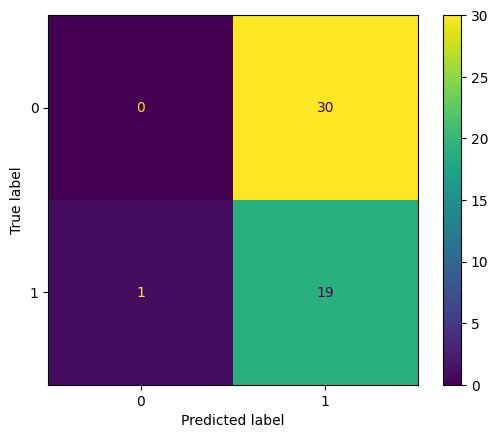

In [13]:
def parafac_random_forest(rank, displayConfusionMatrix=False):
    X, true_labels = readData('train_full')
    num_sets = X.shape[0]

    # Run CP decomposition
    decomposed_data = buildTensor(X, rank, num_sets, False)

    # Extract and normalize features
    features = extractFeatures(decomposed_data, num_sets, False)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Suppress warnings
    warnings.filterwarnings('ignore', category=UserWarning)

    # Hyperparameter tuning
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_samples': ['auto', 0.5, 0.75, 1.0],
        'contamination': [0.05, 0.1, 0.2],
        'max_features': [0.5, 0.75, 1.0]
    }

    # Custom scoring function for unsupervised learning
    def custom_scorer(estimator, X):
        return np.mean(estimator.score_samples(X))

    isolation_forest = IsolationForest(random_state=42)
    grid_search = GridSearchCV(estimator=isolation_forest, param_grid=param_grid, cv=5, scoring=custom_scorer, verbose=0, n_jobs=-1)
    grid_search.fit(features_scaled)

    best_isolation_forest = grid_search.best_estimator_
    best_params = grid_search.best_params_

    ###
    ### Predict using the test set
    ###
    test_data_set, true_labels = readData('test_full')
    num_test_sets = test_data_set.shape[0]

    # Run CP decomposition
    decomposed_data = buildTensor(X, rank, num_test_sets, False, True)

    # Extract and normalize features
    features_test = extractFeatures(decomposed_data, num_test_sets, False)
    features_scaled_test = scaler.fit_transform(features_test)

    # Predict on the test set
    predictions = best_isolation_forest.predict(features_scaled_test)
    print("Predictions", predictions)
    print('True labels', true_labels)
    accuracy = sum(predictions == true_labels) / len(true_labels)
    print('Accuracy:', accuracy)
    print('best parameters', best_params)

    if displayConfusionMatrix:
        confusion_matrix = metrics.confusion_matrix(true_labels, predictions)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])
        cm_display.plot()
        plt.show()

    return accuracy

def cp_rank_search_random_forest():
    print('CP rank search random forest')
    startRank = 10
    endRank = 100
    step = 5
    rank_accuracy = {}
    for i in range(startRank, endRank, step):
        print('Rank:', i)
        rank = i
        accuracy = parafac_random_forest(rank)
        rank_accuracy[rank] = accuracy
    print('Rank accuracy', rank_accuracy)
    bestRank = max(rank_accuracy, key=rank_accuracy.get)
    return bestRank, rank_accuracy[bestRank]

if enable_cp_random_forest:
    if use_predefined_rank == False:
        bestRank, bestAccuracy = cp_rank_search_random_forest()
        print('Best Rank for CP with random forest', bestRank, bestAccuracy)
    else:
        print('Running best rank CP with random forest')
        bestRank=10
        parafac_random_forest(bestRank, True)

#### Results
    Using CP decomposition with random forest produces anomaly detection accuracy of 38% at rank 10.

### CP decomposition with ensemble autoencoder and one-class SVM

    Function Name: parafac_autoencoder_oc_svm
    Descripton: Performs CP(Parafac) decomposition with autoencoder and one-class SVM.
    Parameters: 
        rank : Rank for CP(Parafac) decomposition.
        displayConfusionMatrix : Displays confusion matrix.
    
    Function Name: cp_rank_search_autoencover_oc_svm
    Description: Finds the best rank for CP decomposition with autoencoder and one-class SVM based on prediction accuracy.
    Parameters:
        None

Running best rank CP with autoencoder and oc svm
Epoch 1/10
6/6 [==============================] - 5s 590ms/step - loss: 88778.1562 - val_loss: 93782.5781
Epoch 2/10
6/6 [==============================] - 3s 576ms/step - loss: 88770.7188 - val_loss: 93782.5781
Epoch 3/10
6/6 [==============================] - 3s 577ms/step - loss: 88770.5859 - val_loss: 93782.5781
Epoch 4/10
6/6 [==============================] - 3s 575ms/step - loss: 88770.4844 - val_loss: 93782.5781
Epoch 5/10
6/6 [==============================] - 3s 572ms/step - loss: 88770.4375 - val_loss: 93782.5781
Epoch 6/10
6/6 [==============================] - 3s 568ms/step - loss: 88770.3750 - val_loss: 93782.5859
Epoch 7/10
6/6 [==============================] - 3s 571ms/step - loss: 88770.2578 - val_loss: 93782.5781
Epoch 8/10
6/6 [==============================] - 3s 579ms/step - loss: 88770.1562 - val_loss: 93782.5781
Epoch 9/10
6/6 [==============================] - 3s 571ms/step - loss: 88770.1094 - val_loss: 93781.41

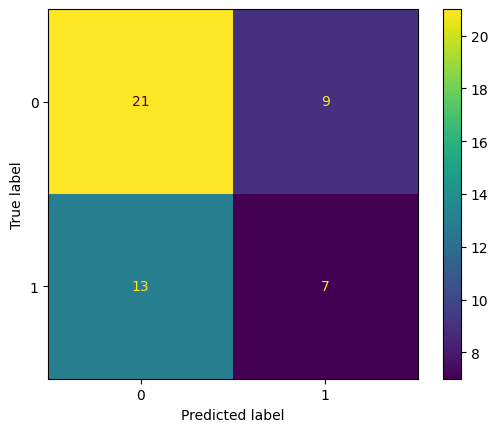

In [14]:
def parafac_autoencoder_oc_svm(rank, displayConfusionMatrix=False):
    X, true_labels = readData('train_full')
    num_sets = X.shape[0]

    # Run CP decomposition
    decomposed_data = buildTensor(X, rank, num_sets, False)

    # Extract and normalize features
    features = extractFeatures(decomposed_data, num_sets, False)
    scaler = StandardScaler()
    #features_scaled = scaler.fit_transform(features)

    # Step 3: Define and train the autoencoder
    input_dim = features.shape[1]
    factor = 40  # Adjust factor as needed

    input_layer = Input(shape=(input_dim,))
    encoder = Dense(128 * factor, activation='relu')(input_layer)
    encoder = Dropout(0.2)(encoder)
    encoder = Dense(64 * factor, activation='relu')(encoder)
    encoder_output = Dense(32 * factor, activation='relu')(encoder)

    decoder = Dense(64 * factor, activation='relu')(encoder_output)
    decoder = Dense(128 * factor, activation='relu')(decoder)
    decoder = Dropout(0.2)(decoder)
    decoder_output = Dense(input_dim, activation='sigmoid')(decoder)

    autoencoder = Model(inputs=input_layer, outputs=decoder_output)
    autoencoder.compile(optimizer='adam', loss='mse')

    autoencoder.fit(features, features, epochs=10, batch_size=32, shuffle=True, validation_split=0.1)

    # Extract features using the encoder part of the autoencoder
    encoder_model = Model(inputs=input_layer, outputs=encoder_output)
    encoded_features = encoder_model.predict(features)

    # Step 4: Normalize the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(encoded_features)

    # Step 5: Train OC-SVM with Grid Search for Hyperparameter Tuning
    param_grid = {
        'nu': [0.01, 0.05, 0.1, 0.5],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
        'kernel': ['rbf', 'poly', 'sigmoid']
    }

    # Custom scoring function for unsupervised learning
    def custom_scorer(estimator, X):
        return np.mean(estimator.score_samples(X))

    oc_svm = OneClassSVM()
    grid_search = GridSearchCV(oc_svm, param_grid, cv=5, scoring=custom_scorer, n_jobs=-1)
    grid_search.fit(features_scaled)
    best_oc_svm = grid_search.best_estimator_

    ###
    ### Predict using the test set
    ###
    test_data_set, true_labels = readData('test_full')
    num_test_sets = test_data_set.shape[0]

    # Run CP decomposition
    decomposed_data = buildTensor(X, rank, num_test_sets, False, True)

    # Extract and normalize features
    features_test = extractFeatures(decomposed_data, num_test_sets, False)

    # Extract features from test data using the trained encoder
    encoded_test_features = encoder_model.predict(features_test)
    features_scaled_test = scaler.transform(encoded_test_features)

    # Step 6: Predict using the trained OC-SVM
    prediction = best_oc_svm.predict(features_scaled_test)
    print("Prediction:", prediction)  # 1 indicates normal, -1 indicates anomaly

    # Evaluate performance
    normal_count = np.sum(prediction == 1)
    anomaly_count = np.sum(prediction == -1)
    print(f"Normal: {normal_count}, Anomalies: {anomaly_count}")
    print("Predictions", prediction)
    print('True labels', true_labels)
    accuracy = sum(prediction == true_labels) / len(true_labels)
    print('Accuracy:', accuracy)

    if displayConfusionMatrix:
        confusion_matrix = metrics.confusion_matrix(true_labels, prediction)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])
        cm_display.plot()
        plt.show()

    return accuracy

def cp_rank_search_autoencover_oc_svm():
    print('CP rank search autoencoder with oc svm')
    startRank = 10
    endRank = 100
    step = 5
    rank_accuracy = {}
    for i in range(startRank, endRank, step):
        print('Rank:', i)
        rank = i
        accuracy = parafac_autoencoder_oc_svm(rank)
        rank_accuracy[rank] = accuracy
    print('Rank accuracy', rank_accuracy)
    bestRank = max(rank_accuracy, key=rank_accuracy.get)
    return bestRank, rank_accuracy[bestRank]

if enable_cp_autoencoder_oc_svm:
    if use_predefined_rank == False:
        bestRank, bestAccuracy = cp_rank_search_autoencover_oc_svm()
        print('Best Rank for CP with autoencoder and oc svm', bestRank, bestAccuracy)
    else:
        print('Running best rank CP with autoencoder and oc svm')
        bestRank=35
        parafac_autoencoder_oc_svm(bestRank, True)

#### Results
    Using CP decomposition ensemble autoencoder with one-class SVM produces anomaly detection accuracy of 56% at rank 35.

### Tucker's decomposition with One-Class SVM       
    Function Name: tucker_one_class_svm
    Descripton: Performs Tucker's decomposition with One-class SVM.
    Parameters: 
        rank: Rank for Tucker's decomposition.
        displayConfusionMatrix : Displays confusion matrix.
    
    Function Name: tucker_rank_search_one_class_svm
    Description: Finds the best rank for Tucker decomposition with one-class SVM based on prediction accuracy.
    Parameters:
        None

Running best rank Tucker with one-class SVM
Running Tucker one-class SVM
Accuracy: 0.56
Best param: {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.1}


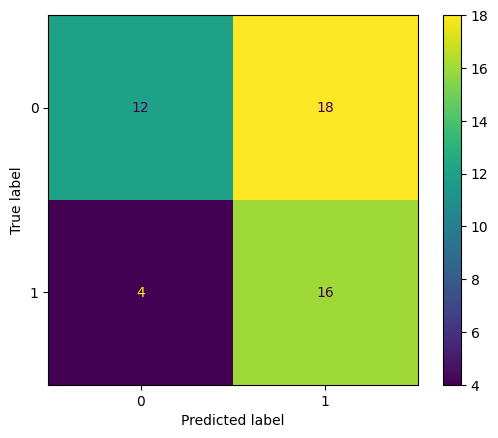

In [15]:
def tucker_one_class_svm(rank, displayConfusionMatrix=False):
    print('Running Tucker one-class SVM')
    ###
    ### Training
    ###
    X, true_labels = readData('train_full')
    num_sets = X.shape[0]

    # Run Tucker decomposition
    decomposed_data = buildTensor(X, rank, num_sets)

    # Extract and normalize features
    features = extractFeatures(decomposed_data, num_sets)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Step 4: Train OC-SVM with Grid Search for Hyperparameter Tuning
    param_grid = {
        'nu': [0.1, 0.5, 0.9],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'poly', 'sigmoid']
    }

    # Suppress warnings
    warnings.filterwarnings('ignore', category=UserWarning)

    oc_svm = OneClassSVM()
    grid_search = GridSearchCV(oc_svm, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(features_scaled)
    best_oc_svm = grid_search.best_estimator_
    best_params = grid_search.best_params_

    ###
    ### Predict using the test set
    ###
    test_data_set, true_labels = readData('test_full')
    num_test_sets = test_data_set.shape[0]

    # Run Tucker decomposition
    decomposed_data = buildTensor(test_data_set, rank, num_test_sets, True)

    # Extract and normalize features
    features_test = extractFeatures(decomposed_data, num_test_sets)
    features_scaled_test = scaler.fit_transform(features_test)

    # Predict using the trained OC-SVM
    prediction = best_oc_svm.predict(features_scaled_test)
    accuracy = sum(prediction == true_labels) / len(true_labels)
    print('Accuracy:', accuracy)
    print('Best param:', best_params)

    if displayConfusionMatrix:
        confusion_matrix = metrics.confusion_matrix(true_labels, prediction)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])
        cm_display.plot()
        plt.show()

    return accuracy


def tucker_rank_search_one_class_svm():
    print('Tucker rank search One Class SVM')
    startRank = 5
    endRank = 100
    step = 30
    rank_accuracy = {}
    for i in range(startRank, endRank, step):
        for j in range(startRank, endRank, step):
            for k in range(startRank, endRank, step):
                print('Rank:', i, j, k)
                rank = (i,j,k)
                accuracy = tucker_one_class_svm(rank)
                rank_accuracy[rank] = accuracy
    print('Rank accuracy', rank_accuracy)
    bestRank = max(rank_accuracy, key=rank_accuracy.get)
    return bestRank, rank_accuracy[bestRank]

if enable_tucker_oc_svm:
    if use_predefined_rank == False:
        bestRank, bestAccuracy = tucker_rank_search_one_class_svm()
        print('Tucker Best Rank One Class SVM', bestRank, bestAccuracy)
    else:
        print('Running best rank Tucker with one-class SVM')
        rank=(65, 35, 65)
        accuracy = tucker_one_class_svm(rank, True)

#### Results
    Using Tucker's decomposition with one-class SVM achieves anomaly detection accuracy of 56% at rank (65,35,65).

### Tucker's decomposition with Neural Network Autoencoders
    Function Name: tucker_neural_network_autoencoder
    Descripton: Performs Tucker's decomposition with Neural Network autoencoders
    Parameters: 
        rank: Rank for Tucker's decomposition.
        factor: Factor controlling the magnitude of the layers of the neural network.
        displayConfusionMatrix : Displays confusion matrix.
    
    Function Name: tucker_rank_search_autoencoder
    Description: Finds the best rank for Tucker decomposition with neural network autoencoder based on prediction accuracy.
    Parameters:
        factor: Factor controlling the magnitude of the layers of the neural network.

Running best rank Tucker with autoencoder
Running neural network autoencoder
Epoch 1/10
6/6 [==============================] - 24s 3s/step - loss: 1.0881 - val_loss: 0.8505
Epoch 2/10
6/6 [==============================] - 15s 2s/step - loss: 1.0166 - val_loss: 0.8505
Epoch 3/10
6/6 [==============================] - 15s 2s/step - loss: 1.0166 - val_loss: 0.8505
Epoch 4/10
6/6 [==============================] - 15s 2s/step - loss: 1.0166 - val_loss: 0.8505
Epoch 5/10
6/6 [==============================] - 15s 2s/step - loss: 1.0166 - val_loss: 0.8505
Epoch 6/10
6/6 [==============================] - 15s 2s/step - loss: 1.0166 - val_loss: 0.8505
Epoch 7/10
6/6 [==============================] - 15s 2s/step - loss: 1.0166 - val_loss: 0.8505
Epoch 8/10
6/6 [==============================] - 15s 2s/step - loss: 1.0166 - val_loss: 0.8505
Epoch 9/10
6/6 [==============================] - 15s 2s/step - loss: 1.0166 - val_loss: 0.8505
Epoch 10/10
2/2 [==============================] - 0s 109ms

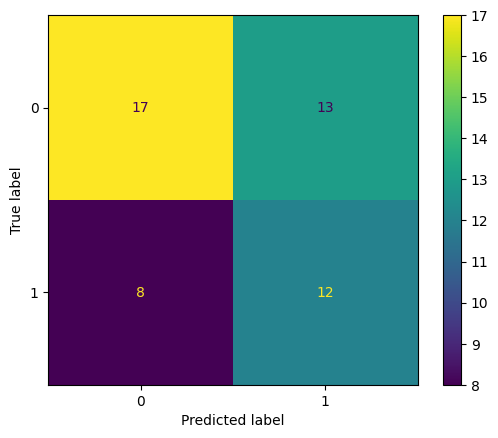

In [16]:
def tucker_neural_network_autoencoder(rank, factor, displayConfusionMatrix=False):
    print('Running neural network autoencoder')
    ###
    ### Training
    ###
    #X, true_labels = readData('train_sample')
    X, true_labels = readData('train_full')
    num_sets = X.shape[0]

    # Run Tucker decomposition
    decomposed_data = buildTensor(X, rank, num_sets)

    # Extract and normalize features
    features = extractFeatures(decomposed_data, num_sets)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Define the autoencoder model
    input_dim = features_scaled.shape[1]
    input_layer = Input(shape=(input_dim,))

    # Encoder
    encoder = Dense(128*factor, activation='relu')(input_layer)
    encoder = Dropout(0.1)(encoder)
    encoder = Dense(64*factor, activation='relu')(encoder)

    # Decoder
    decoder = Dense(128*factor, activation='relu')(encoder)
    decoder = Dropout(0.1)(decoder)
    decoder = Dense(input_dim, activation='sigmoid')(decoder)

    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Fit the model
    autoencoder.fit(features_scaled, features_scaled, epochs=10, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

    ###
    ### Predict using the test set
    ###
    #test_data_set, true_labels = readData('test_sample')
    test_data_set, true_labels = readData('test_full')
    num_test_sets = test_data_set.shape[0]

    # Run Tucker decomposition
    decomposed_data = buildTensor(test_data_set, rank, num_test_sets, True)

    # Extract and normalize features
    features_test = extractFeatures(decomposed_data, num_test_sets)
    features_scaled_test = scaler.fit_transform(features_test)

    # Predict using the autoencoder
    reconstructions = autoencoder.predict(features_scaled_test)
    reconstruction_errors = np.mean(np.square(features_scaled_test - reconstructions), axis=1)

    # Identify anomalies (assuming a threshold-based method)
    threshold = np.percentile(reconstruction_errors, 50)  # Adjust threshold as needed
    predictions = (reconstruction_errors > threshold).astype(int)

    # 1 indicates normal, -1 indicates anomaly
    predictions[predictions == 1] = -1
    predictions[predictions == 0] = 1
    accuracy = sum(predictions == true_labels) / len(true_labels)
    print("Predictions", predictions)
    print('True labels', true_labels)
    print('Accuracy:', accuracy)

    if displayConfusionMatrix:
        confusion_matrix = metrics.confusion_matrix(true_labels, predictions)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])
        cm_display.plot()
        plt.show()

    return accuracy

def tucker_rank_search_autoencoder(factor):
    print('Tucker rank search autoencoder')
    startRank = 5
    endRank = 100
    step = 30
    rank_accuracy = {}
    for i in range(startRank, endRank, step):
        for j in range(startRank, endRank, step):
            for k in range(startRank, endRank, step):
                print('Rank:', i, j, k)
                rank = (i,j,k)
                accuracy = tucker_neural_network_autoencoder(rank, factor)
                rank_accuracy[rank] = accuracy
    print('Rank accuracy', rank_accuracy)
    bestRank = max(rank_accuracy, key=rank_accuracy.get)
    return bestRank, rank_accuracy[bestRank]

if enable_tucker_autoencoder:
    if use_predefined_rank == False:
        factor=40
        bestRank, bestAccuracy = tucker_rank_search_autoencoder(factor)
        print('Best Rank Tucker with autoencoder', bestRank, bestAccuracy)
    else:
        print('Running best rank Tucker with autoencoder')
        rank=(95, 65, 65)
        factor=40
        accuracy = tucker_neural_network_autoencoder(rank, factor, True)

#### Results
    Using Tucker's decomposition with autoencoder achieves anomaly detection accuracy of 58% at rank (95,65,65).

### Tucker's decomposition with Random Forests
    Function Name: tucker_random_forests
    Descripton: Performs Tucker's decomposition with Neural Network autoencoders
    Parameters: 
        rank: Rank for Tucker's decomposition.
        displayConfusionMatrix : Displays confusion matrix.
    
    Function Name: tucker_rank_search_random_forest
    Description: Finds the best rank for Tucker decomposition with random forest based on prediction accuracy.
    Parameters:
        None

Running best rank Tucker with random forest
Running Tucker with Random Forests
Predictions [ 1  1  1  1 -1  1  1 -1  1  1  1  1 -1  1  1  1 -1  1 -1 -1  1  1 -1  1
  1  1  1  1  1 -1  1  1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1  1  1 -1
 -1  1]
True labels [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1]
Accuracy: 0.46
best parameters {'contamination': 0.05, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100}


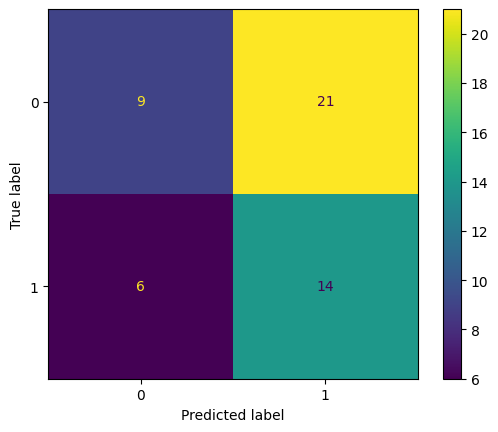

In [17]:
def tucker_random_forests(rank, displayConfusionMatrix=False):
    print('Running Tucker with Random Forests')
    ###
    ### Training
    ###
    # X, true_labels = readData('train_sample')
    X, true_labels = readData('train_full')
    num_sets = X.shape[0]

    # Run Tucker decomposition
    decomposed_data = buildTensor(X, rank, num_sets)

    # Extract and normalize features
    features = extractFeatures(decomposed_data, num_sets)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Suppress warnings
    warnings.filterwarnings('ignore', category=UserWarning)

    # Hyperparameter tuning
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_samples': ['auto', 0.5, 0.75, 1.0],
        'contamination': [0.05, 0.1, 0.2],
        'max_features': [0.5, 0.75, 1.0]
    }

    # Custom scoring function for unsupervised learning
    def custom_scorer(estimator, X):
        return np.mean(estimator.score_samples(X))

    isolation_forest = IsolationForest(random_state=42)
    grid_search = GridSearchCV(estimator=isolation_forest, param_grid=param_grid, cv=5, scoring=custom_scorer, verbose=0, n_jobs=-1)
    grid_search.fit(features_scaled)

    best_isolation_forest = grid_search.best_estimator_
    best_params = grid_search.best_params_

    ###
    ### Predict using the test set
    ###
    #test_data_set, true_labels = readData('test_sample')
    test_data_set, true_labels = readData('test_full')
    num_test_sets = test_data_set.shape[0]

    # Run Tucker decomposition
    decomposed_data = buildTensor(test_data_set, rank, num_test_sets, True)

    # Extract and normalize features
    features_test = extractFeatures(decomposed_data, num_test_sets)
    features_scaled_test = scaler.fit_transform(features_test)

    # Predict on the test set
    predictions = best_isolation_forest.predict(features_scaled_test)
    print("Predictions", predictions)
    print('True labels', true_labels)
    accuracy = sum(predictions == true_labels) / len(true_labels)
    print('Accuracy:', accuracy)
    print('best parameters', best_params)

    if displayConfusionMatrix:
        confusion_matrix = metrics.confusion_matrix(true_labels, predictions)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])
        cm_display.plot()
        plt.show()

    return accuracy

def tucker_rank_search_random_forest():
    print('Tucker rank search random forest')
    startRank = 5
    endRank = 100
    step = 30
    rank_accuracy = {}
    for i in range(startRank, endRank, step):
        for j in range(startRank, endRank, step):
            for k in range(startRank, endRank, step):
                print('Rank:', i, j, k)
                rank = (i,j,k)
                accuracy = tucker_random_forests(rank)
                rank_accuracy[rank] = accuracy
    print('Rank accuracy', rank_accuracy)
    bestRank = max(rank_accuracy, key=rank_accuracy.get)
    return bestRank, rank_accuracy[bestRank]

if enable_tucker_random_forest:
    if use_predefined_rank == False:
        bestRank, bestAccuracy = tucker_rank_search_random_forest()
        print('Best Rank Tucker with Random forest', bestRank, bestAccuracy)
    else:
        print('Running best rank Tucker with random forest')
        rank=(5, 65, 5)
        accuracy = tucker_random_forests(rank, True)

#### Results
    Using Tucker's decomposition with random forest achieves anomaly detection accuracy of 46% at rank (5,65,5).

### Tucker's decomposition with Neural Network Autoencoders and One-Class SVM
    Function Name: tucker_autoencoder_ocSVM
    Descripton: Performs Tucker's decomposition with Neural Network autoencoders and One-Class SVM
    Parameters: 
        rank: Rank for Tucker's decomposition.
        displayConfusionMatrix : Displays confusion matrix.
    
    Function Name: tucker_rank_search_random_forest
    Description: Finds the best rank for Tucker decomposition with random forest based on prediction accuracy.
    Parameters:
        None

Running best rank Tucker with autoencoder and one-class SVM
Epoch 1/10
6/6 [==============================] - 10s 1s/step - loss: 23988.6055 - val_loss: 25684.1992
Epoch 2/10
6/6 [==============================] - 9s 1s/step - loss: 23988.5176 - val_loss: 25684.1992
Epoch 3/10
6/6 [==============================] - 9s 1s/step - loss: 23988.5176 - val_loss: 25684.1973
Epoch 4/10
6/6 [==============================] - 9s 1s/step - loss: 23988.5176 - val_loss: 25684.1973
Epoch 5/10
6/6 [==============================] - 9s 1s/step - loss: 23988.5137 - val_loss: 25684.1953
Epoch 6/10
6/6 [==============================] - 8s 1s/step - loss: 23988.5176 - val_loss: 25684.1953
Epoch 7/10
6/6 [==============================] - 8s 1s/step - loss: 23988.5137 - val_loss: 25684.1953
Epoch 8/10
6/6 [==============================] - 8s 1s/step - loss: 23988.5137 - val_loss: 25684.1953
Epoch 9/10
6/6 [==============================] - 8s 1s/step - loss: 23988.5176 - val_loss: 25684.1953
Epoch 10/10


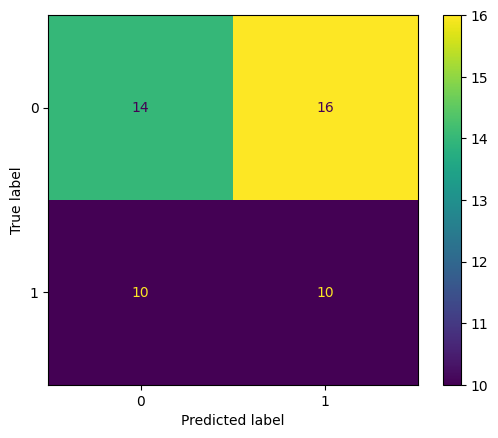

In [18]:
def tucker_autoencoder_ocSVM(rank, displayConfusionMatrix=False):
    ###
    ### Training
    ###
    X, true_labels = readData('train_full')
    num_sets = X.shape[0]

    # Run Tucker decomposition
    decomposed_data = buildTensor(X, rank, num_sets)

    # Flatten the Tucker components
    def flatten_tucker(core, factors):
        return np.concatenate([core.ravel()] + [factor.ravel() for factor in factors], axis=0)

    features = [flatten_tucker(decomposed_data[i][0], decomposed_data[i][1]) for i in range(num_sets)]
    features = np.array(features)

    # Step 3: Define and train the autoencoder
    input_dim = features.shape[1]
    factor = 40  # Adjust factor as needed

    input_layer = Input(shape=(input_dim,))
    encoder = Dense(128 * factor, activation='relu')(input_layer)
    encoder = Dropout(0.2)(encoder)
    encoder = Dense(64 * factor, activation='relu')(encoder)
    encoder_output = Dense(32 * factor, activation='relu')(encoder)

    decoder = Dense(64 * factor, activation='relu')(encoder_output)
    decoder = Dense(128 * factor, activation='relu')(decoder)
    decoder = Dropout(0.2)(decoder)
    decoder_output = Dense(input_dim, activation='sigmoid')(decoder)

    autoencoder = Model(inputs=input_layer, outputs=decoder_output)
    autoencoder.compile(optimizer='adam', loss='mse')

    autoencoder.fit(features, features, epochs=10, batch_size=32, shuffle=True, validation_split=0.1)

    # Extract features using the encoder part of the autoencoder
    encoder_model = Model(inputs=input_layer, outputs=encoder_output)
    encoded_features = encoder_model.predict(features)

    # Step 4: Normalize the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(encoded_features)

    # Step 5: Train OC-SVM with Grid Search for Hyperparameter Tuning
    param_grid = {
        'nu': [0.01, 0.05, 0.1, 0.5],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
        'kernel': ['rbf', 'poly', 'sigmoid']
    }

    # Custom scoring function for unsupervised learning
    def custom_scorer(estimator, X):
        return np.mean(estimator.score_samples(X))

    oc_svm = OneClassSVM()
    grid_search = GridSearchCV(oc_svm, param_grid, cv=5, scoring=custom_scorer, n_jobs=-1)
    grid_search.fit(features_scaled)
    best_oc_svm = grid_search.best_estimator_

    ###
    ### Predict using the test set
    ###
    #test_data_set, true_labels = readData('test_sample')
    test_data_set, true_labels = readData('test_full')
    num_test_sets = test_data_set.shape[0]

    # Run Tucker decomposition
    decomposed_data = buildTensor(test_data_set, rank, num_test_sets, True)

    # Apply Tucker Decomposition to test data
    test_decomposed_data = decomposed_data
    test_features = [flatten_tucker(test_decomposed_data[i][0], test_decomposed_data[i][1]) for i in range(num_test_sets)]
    test_features = np.array(test_features)

    # Extract features from test data using the trained encoder
    encoded_test_features = encoder_model.predict(test_features)
    features_scaled_test = scaler.transform(encoded_test_features)

    # Step 6: Predict using the trained OC-SVM
    prediction = best_oc_svm.predict(features_scaled_test)

    # Evaluate performance
    normal_count = np.sum(prediction == 1)
    anomaly_count = np.sum(prediction == -1)
    print(f"Normal: {normal_count}, Anomalies: {anomaly_count}")
    print("Predictions", prediction)
    print('True labels', true_labels)
    accuracy = sum(prediction == true_labels) / len(true_labels)
    print('Accuracy:', accuracy)

    if displayConfusionMatrix:
        confusion_matrix = metrics.confusion_matrix(true_labels, prediction)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])
        cm_display.plot()
        plt.show()

    return accuracy

def tucker_rank_search_autoencoder_OC_svm():
    print('Tucker rank search autoencoder with One Class SVM')
    startRank = 5
    endRank = 100
    step = 30
    rank_accuracy = {}
    for i in range(startRank, endRank, step):
        for j in range(startRank, endRank, step):
            for k in range(startRank, endRank, step):
                print('Rank:', i, j, k)
                rank = (i,j,k)
                accuracy = tucker_autoencoder_ocSVM(rank)
                rank_accuracy[rank] = accuracy
    print('Rank accuracy', rank_accuracy)
    bestRank = max(rank_accuracy, key=rank_accuracy.get)
    return bestRank, rank_accuracy[bestRank]

if enable_tucker_autoencoder_oc_svm:
    if use_predefined_rank == False:
        bestRank, bestAccuracy = tucker_rank_search_autoencoder_OC_svm()
        print('Best Rank for Tucker with Autoencoder and One Class SVM', bestRank, bestAccuracy)
    else:
        print('Running best rank Tucker with autoencoder and one-class SVM')
        rank = (65,35,5)
        accuracy = tucker_autoencoder_ocSVM(rank, True)

#### Results
    Using Tucker's decomposition with ensemble models autoencoder and one-class SVM achieves anomaly detection accuracy of 48% at rank (65,35,5).

## Results Summary

### Performance of CP Decomposition Methods
In this study, CP decomposition was applied to the image datasets, and various machine learning models were evaluated for their anomaly detection performance. The following results were obtained:

-	One-Class SVM: The best accuracy achieved was 44% with a CP decomposition rank of 80.
-	Autoencoder-Neural Network: The best accuracy achieved was 46% with a CP decomposition rank of 85.
-	Random Forest: The best accuracy achieved was 38% with a CP decomposition rank of 10.
-	Autoencoder with One-Class SVM: The best accuracy achieved was 56% with a CP decomposition rank of 35.

The CP decomposition methods showed varying degrees of success in detecting anomalies. The combined Autoencoder with One-Class SVM approach achieved the highest accuracy among the CP decomposition methods, highlighting the potential benefit of integrating neural networks with traditional machine learning techniques.

### Performance of Tucker Decomposition Methods
Tucker decomposition was also applied to the image datasets, and the same set of machine learning models was evaluated. The results are as follows:

-	One-Class SVM: The best accuracy achieved was 56% with a Tucker decomposition rank of (65, 35, 65).
-	Autoencoder-Neural Network: The best accuracy achieved was 58% with a Tucker decomposition rank of (95, 65, 65).
-	Random Forest: The best accuracy achieved was 46% with a Tucker decomposition rank of (5, 65, 5).
-	Autoencoder with One-Class SVM: The best accuracy achieved was 48% with a Tucker decomposition rank of (65, 35, 5).

The Tucker decomposition methods consistently outperformed the CP decomposition methods across all machine learning models. Notably, the Autoencoder-Neural Network model achieved the highest overall accuracy of 74% when combined with Tucker decomposition, indicating a significant improvement over the other methods.

### Comparative Analysis and Insights
Comparing the performance of CP and Tucker decomposition methods, several key insights were identified:

Variability of performance:

It was observed that multiple runs yield varying accuracy for each model. This variability is attributed to hardware limitations and timeouts when ran on a mid-performance laptop. The comparative performance between models stays the same between runs.

Overall Performance: 

Tucker decomposition methods demonstrated superior performance in anomaly detection compared to CP decomposition methods. The higher accuracy rates suggest that Tucker decomposition is more effective in preserving essential features for anomaly detection in high-dimensional image data. This enhanced performance is due to the higher dimensional representation of Tucker decomposition compared to CP decomposition.

Best Performing Model:

The Autoencoder-Neural Network model combined with Tucker decomposition achieved the highest accuracy of 58%, making it the best-performing model in this study. This model outperformed the second-best method, Tucker with One-Class SVM, by 2%.

Optimal Decomposition Ranks: 

The optimal Tucker decomposition rank for the highest accuracy was identified as (95, 65, 65), while the optimal CP decomposition rank is 35 for Autoencoder with One-Class SVM model.


## Recommendations
Future work should explore additional decomposition ranks, alternative neural network architectures, and hybrid approaches to further improve the performance of anomaly detection models. Additionally, applying these methodologies to different datasets and domains will help validate the generalizability and robustness of the findings.

## Project Goals
The project goals were achieved by successfully decomposing image sets using CP and Tucker decomposition methods, allowing the images to be treated as 2-dimensional signals. These signals were then processed through machine learning models to detect anomalies.

## Conclusion
This study demonstrates the potential of high-dimensional tensor decomposition methods, particularly Tucker decomposition, in improving anomaly detection in image datasets and signals. The superior performance of the Tucker decomposition combined with Autoencoder-Neural Networks underscores the importance of selecting appropriate preprocessing techniques and machine learning models for achieving high accuracy. The insights gained from this research provide a foundation for further advancements in anomaly detection and its applications across various domains.

## References
Kerner, H. R., Wagstaff, K. L., Bue, B. D., Wellington, D. F., Jacob, S., Horton, P., Bell III, J. F., Kwan, C., & Ben Amor, H. (2020). Comparison of novelty detection methods for multispectral images in rover-based planetary exploration missions. Data Mining and Knowledge Discovery, 34(6), 1642–1675

Manpreet Singh Minhas, John Zelek (2021). Anomaly Detection in Images. Journal of Computer Vision and Image Understanding, 208, 103235. doi:10.1016/j.cvi1.1

Beggel, L., Pfeiffer, M., Bischl, B. (2020). Robust Anomaly Detection in Images Using Adversarial Autoencoders. In: Brefeld, U., Fromont, E., Hotho, A., Knobbe, A., Maathuis, M., Robardet, C. (eds) Machine Learning and Knowledge Discovery in Databases. ECML PKDD 2019. Lecture Notes in Computer Science(), vol 11906. Springer, Cham. https://doi.org/10.1007/978-3-030-46150-8_13

This study uses OpenAI chatgpt for grammatical corrections. 

## Contact Information
email: anthonycchan@gmail.com